In [ ]:
#!pip3 install requests soupsieve lxml
#!pip3 install beautifulsoup4
#!pip3 install requests
#!pip install html5lib
#!pip install GetOldTweets3
#!pip install searchtweets
#!pip install tweepy

In [19]:
import pandas as pd
import requests
import csv
import time
import random
from bs4 import BeautifulSoup
from datetime import datetime
import GetOldTweets3 #as got

# Reddit

In [2]:
#Webpage URL
url = "https://old.reddit.com/r/MachineLearning/"

# Headers to mimic a browser visit
headers = {'User-Agent': 'Mozilla/5.0'}

# Returns a requests.models.Response object
page = requests.get(url, headers=headers)

#Create variable for Beautiful Soup object
soup = BeautifulSoup(page.text, 'html.parser')

#Find all the 'span' tags with 'domain' inside
for domain in soup.find_all("span", class_="domain"):
    if domain.text != "(self.MachineLearning)":
        continue
    #print(domain.parent.parent.parent.parent)
    parent_div = domain.parent.parent.parent.parent

In [3]:
#
attrs = {'class': 'thing', 'data-domain': 'self.MachineLearning'}

df_reddit = pd.DataFrame()
title_lst = []
author_lst = []
date_lst = []
num_comments_lst = []
likes_lst = []
counter = 1

while (counter <= 100):
    for post in soup.find_all('div', attrs=attrs):

        #Obtain title, author, number of comments, and likes
        try:
            title = post.find('p', class_="title").text.split(']')[1].split('(')[0]
        except:
            title = post.find('p', class_="title").text
        author = post.find('a', class_='author').text
        date = post.find('time')['datetime'].split('T')[0]

        comments = post.find('a', class_='comments').text.split()[0]
        if comments == "comment":
            comments = 0

        likes = post.find("div", attrs={"class": "score likes"}).text
        if likes == "•":
            likes = "None"

        #df_dict.update({'title':title, 'author':author,'num_comments':comments, 'likes':likes})

        title_lst.append(title)
        author_lst.append(author)
        date_lst.append(date)
        num_comments_lst.append(comments)
        likes_lst.append(likes)

    #
    try:
        next_button = soup.find("span", class_="next-button")
    except:
        pass
    try:
        next_page_link = next_button.find("a").attrs['href']
    except: 
        pass

    time.sleep(2)
    page = requests.get(next_page_link, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    counter += 1
    if counter>200:
        break
        
df_reddit = pd.DataFrame({'title':title_lst,'author':author_lst, 'date':date,
                   'num_comments':num_comments_lst,'likes':likes_lst})

In [4]:
df_reddit.shape

(1301, 5)

In [1]:
df_reddit.sample(20)

NameError: name 'df_reddit' is not defined

In [6]:
df_reddit.to_csv('reddit_data.csv', index=False)

# Twitter

In [200]:
import tweepy
import sys

class MyStreamListener(tweepy.StreamListener):
    def on_status(self,status):
        print(status.text)
    def on_error(self,status_code):
        print(status_code)


#INSERT CODE HERE


auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

if (not api):
    print("Authentication failed!")
    sys.exit(-1)

#myStreamListener = MyStreamListener()
#myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
#myStream.filter(track=["news"])

In [16]:
twitter_names = open('ml.txt','r')

In [17]:
count = 0
twitterID = []

while True:
    count += 1
    
    #Read line of text
    line = twitter_names.readline()
    if not line:
        break
    twitterID.append(line.split('\n')[0])
    
twitter_names.close()

In [226]:
twitter_user = []
twitter_date = []
twitter_text = []
twitter_fav = []
twitter_retweet = []

In [235]:
for user in twitterID:
    tweet = api.user_timeline(screen_name=user, 
                               # 200 is the maximum allowed count
                               count=200,
                               include_rts = False,
                               # Necessary to keep full_text 
                               # otherwise only the first 140 words are extracted
                               tweet_mode = 'extended'
                               )
    for info in tweet:
        twitter_user.append(user)
        twitter_date.append(info.created_at)
        twitter_text.append(info.full_text)
        twitter_fav.append(info.favorite_count)
        twitter_retweet.append(info.retweet_count)

In [236]:
df_twitter = pd.DataFrame({'user':twitter_user,'date':twitter_date, 'text':twitter_text,
                   'num_favorites':twitter_fav,'num_retweets':twitter_retweet})

In [21]:
df_twitter.shape

(2640, 6)

In [239]:
df_twitter.to_csv('twitter_data.csv')

In [20]:
df_twitter = pd.read_csv('twitter.csv')

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'num_favorites'}>],
       [<AxesSubplot:title={'center':'num_retweets'}>, <AxesSubplot:>]],
      dtype=object)

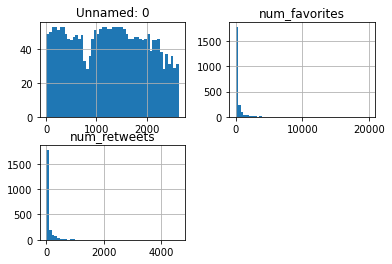

In [20]:
df_twitter[df_twitter['num_favorites'] > 0].hist(bins=50)

# Medium

In [7]:
#Code taken from https://medium.com/the-innovation/scraping-medium-with-python-beautiful-soup-3314f898bbf5
urls = {'Towards Data Science': 'https://towardsdatascience.com/archive/{0}/{1:02d}/{2:02d}'}

def convert_day(day):
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    m = 0
    d = 0
    while day > 0:
        d = day
        day -= month_days[m]
        m += 1
    return (m, d)

def get_claps(claps_str):
    if (claps_str is None) or (claps_str == '') or (claps_str.split is None):
        return 0
    split = claps_str.split('K')
    claps = float(split[0])
    claps = int(claps*1000) if len(split) == 2 else int(claps)
    return claps

selected_days = random.sample([i for i in range(1, 366)], 200)

In [8]:
data = []
article_id = 0
year = 2020
i = 0
n = len(selected_days)
for d in selected_days:
    i += 1
    month, day = convert_day(d)
    date = '{0}-{1:02d}-{2:02d}'.format(year, month, day)
    print(f'{i} / {n} ; {date}')
    for publication, url in urls.items():
        response = requests.get(url.format(year, month, day), allow_redirects=True)
        if not response.url.startswith(url.format(year, month, day)):
            continue
        page = response.content
        soup = BeautifulSoup(page, 'html.parser')
        articles = soup.find_all(
            "div",
            class_="postArticle postArticle--short js-postArticle js-trackPostPresentation js-trackPostScrolls")
        for article in articles:
            title = article.find("h3", class_="graf--title")
            if title is None:
                continue
            title = title.contents[0]
            article_id += 1
            subtitle = article.find("h4", class_="graf--subtitle")
            subtitle = subtitle.contents[0] if subtitle is not None else ''
            claps = get_claps(article.find_all("button")[1].contents[0])
            responses = article.find_all("a")
            if len(responses) == 7:
                responses = responses[6].contents[0].split(' ')
                if len(responses) == 0:
                    responses = 0
                else:
                    responses = responses[0]
            else:
                responses = 0

            data.append([article_id, title, subtitle,
                         claps, responses,
                         publication, date])

1 / 200 ; 2020-10-21
2 / 200 ; 2020-12-16
3 / 200 ; 2020-09-09
4 / 200 ; 2020-05-24
5 / 200 ; 2020-11-04
6 / 200 ; 2020-04-03
7 / 200 ; 2020-07-11
8 / 200 ; 2020-12-14
9 / 200 ; 2020-04-02
10 / 200 ; 2020-01-15
11 / 200 ; 2020-05-19
12 / 200 ; 2020-06-05
13 / 200 ; 2020-08-16
14 / 200 ; 2020-05-30
15 / 200 ; 2020-10-07
16 / 200 ; 2020-06-13
17 / 200 ; 2020-11-25
18 / 200 ; 2020-05-12
19 / 200 ; 2020-06-23
20 / 200 ; 2020-10-23
21 / 200 ; 2020-03-21
22 / 200 ; 2020-01-28
23 / 200 ; 2020-12-13
24 / 200 ; 2020-08-23
25 / 200 ; 2020-02-01
26 / 200 ; 2020-06-30
27 / 200 ; 2020-09-06
28 / 200 ; 2020-08-11
29 / 200 ; 2020-12-17
30 / 200 ; 2020-04-18
31 / 200 ; 2020-03-22
32 / 200 ; 2020-07-19
33 / 200 ; 2020-10-31
34 / 200 ; 2020-11-26
35 / 200 ; 2020-02-22
36 / 200 ; 2020-04-26
37 / 200 ; 2020-12-10
38 / 200 ; 2020-12-25
39 / 200 ; 2020-09-30
40 / 200 ; 2020-12-20
41 / 200 ; 2020-07-04
42 / 200 ; 2020-12-05
43 / 200 ; 2020-05-07
44 / 200 ; 2020-12-30
45 / 200 ; 2020-12-04
46 / 200 ; 2020-06-

In [9]:
medium_df = pd.DataFrame(data, columns=[
    'id', 'title', 'subtitle',
    'claps', 'responses',
    'publication', 'date'])

In [10]:
medium_df.shape

(10011, 7)

In [11]:
medium_df.to_csv('medium_data.csv', index=False)

In [4]:
medium_df = pd.read_csv('medium_data.csv')

<AxesSubplot:>

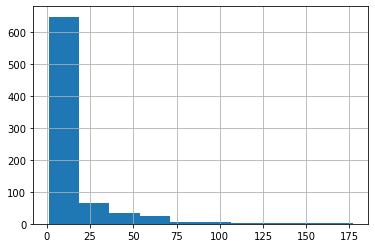

In [8]:
medium_df['claps'].value_counts().hist()